In [1]:
import os
import re
import nltk
import ssl
import json
import joblib
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import zipfile

from warnings import filterwarnings
filterwarnings('ignore')

pd.options.mode.chained_assignment = None

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = os.path.join(os.getcwd(), '..', '.kaggle')
os.environ['WANDB_DISABLED'] = 'true'

In [3]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ilyas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ilyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gerhardien/text-emotion-indonesia

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
with zipfile.ZipFile('text-emotion-indonesia.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [6]:
df1 = pd.read_csv('dataset/train_filtered.csv')
df2 = pd.read_csv('dataset/test_filtered.csv')
df3 = pd.read_csv('dataset/val_filtered.csv')

df = pd.concat([df1, df2, df3], ignore_index=True)

df

,label,sentence
0,sadness,aku telah belajar bahwa bahkan ketika aku mera...
1,sadness,aku tahu bagaimana rasanya menderita sakit dan...
2,neutral,Ucapkan selamat tinggal pada vas defferens dan...
3,neutral,Aku tak sabar menunggu Narratif ini berhenti.
4,neutral,Aku meninggalkannya karena aku mencoba untuk m...
...,...,...
14104,anger,saya merasa hal-hal kecil tapi tidak sejauh ba...
14105,joy,saya merasa bangga untuk mengumumkan bahwa dr
14106,sadness,saya am dalam gaya korban benar merasa malu un...
14107,sadness,Saya telah diberkati dengan pengetahuan tentan...


In [7]:
df.isnull().sum()

label       0
sentence    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14109 entries, 0 to 14108
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     14109 non-null  object
 1   sentence  14109 non-null  object
dtypes: object(2)
memory usage: 220.6+ KB


In [9]:
label_counts = df['label'].value_counts()
print(label_counts)

label
joy        4797
sadness    4250
neutral    2904
anger      2158
Name: count, dtype: int64


In [10]:
avg_count = int(label_counts.mean())
print(avg_count)

3527


In [11]:
df_sampled = df.groupby('label').apply(lambda x: x.sample(avg_count, replace=len(x) < avg_count)).reset_index(drop=True)

In [12]:
print(df_sampled['label'].value_counts())

label
anger      3527
joy        3527
neutral    3527
sadness    3527
Name: count, dtype: int64


In [13]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Slang dictionary
        self.slangwords = {
            "@": "di", "abis": "habis", "masi": "masih", "gua": "saya", "gw": "saya", "klo": "kalau", "afk": "tidak aktif",
            "thx": "terima kasih", "ty": "terima kasih", "tq": "terima kasih", "bgt": "banget", "maks": "maksimal",
            "gg": "hebat", "noob": "pemula", "poke": "pemula", "op": "terlalu kuat", "ez": "mudah", "dll": "dan lain lain"
        }

        # Stemmer dan stopwords
        self.stemmer = StemmerFactory().create_stemmer()

        stopword_factory = StopWordRemoverFactory()
        self.stopwords = set(stopword_factory.get_stop_words())
        self.stopwords.update(stopwords.words('english'))
        self.stopwords.update([
            'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', "di", "ga",
            "ya", "gaa", "loh", "kah", "woi", "woii", "woy", "nge"
        ])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(text) for text in X]

    def _preprocess(self, text):
        text = self._cleaningText(text)
        text = text.lower()
        text = self._fix_slangwords(text)
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in self.stopwords]
        tokens = [self.stemmer.stem(token) for token in tokens]
        return tokens

    def _cleaningText(self, text):
        emoticon_pattern = re.compile(
            "["u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)

        text = emoticon_pattern.sub(r'', text)
        text = re.sub(r'@[A-Za-z0-9]+', '', text)
        text = re.sub(r'#[A-Za-z0-9]+', '', text)
        text = re.sub(r'RT[\s]', '', text)
        text = re.sub(r"http\S+", '', text)
        text = re.sub(r'[0-9]+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        text = text.replace('\n', ' ')
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.strip()
        return text

    def _fix_slangwords(self, text):
        words = text.split()
        fixed_words = [self.slangwords.get(word, word) for word in words]
        return ' '.join(fixed_words)

In [14]:
# Inisialisasi preprocessor
preprocessor = TextPreprocessor()

# Simpan ke file
joblib.dump(preprocessor, 'text_preprocessor.joblib')

['text_preprocessor.joblib']

In [15]:
preprocessor = joblib.load('text_preprocessor.joblib')

In [16]:
df_sampled['cleaned_sentence'] = preprocessor.transform(df_sampled['sentence'])

In [17]:
df_sampled.head(5)

,label,sentence,cleaned_sentence
0,anger,saya mengatakan apa yang saya merasa perlu dik...,"[kata, apa, rasa, perlu, kata, rasa, bitchy]"
1,anger,saya jauh di belakang dengan pekerjaan saya pa...,"[jauh, belakang, kerja, novel, fantasi, rasa, ..."
2,anger,saya merasa sedikit tidak puas dengan jaringan...,"[rasa, sedikit, puas, jaring]"
3,anger,saya tidak merasa seperti saya berada di tepi ...,"[rasa, ada, tepi, titik, mana, ganggu, siapa, ..."
4,anger,saya hanya ingin dia melihat bagaimana rasanya...,"[lihat, bagaimana, rasa, laku, rasa, jengkel]"


In [18]:
df_sampled['text'] = df_sampled['cleaned_sentence'].apply(lambda x: ' '.join(x))  # Ubah list token menjadi string

le = LabelEncoder()
df_sampled['label_encoded'] = le.fit_transform(df_sampled['label'])

label_to_id = dict(zip(le.classes_, le.transform(le.classes_)))
id_to_label = dict(zip(le.transform(le.classes_), le.classes_))

print("Label to ID mapping:", label_to_id)
print("ID to Label mapping:", id_to_label)

# Menyimpan mapping ke JSON
mapping = {
    'label_to_id': label_to_id,
    'id_to_label': {str(k): v for k, v in id_to_label.items()},  # Convert int keys to string for JSON
    'classes': le.classes_.tolist()
}

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    df_sampled['text'], df_sampled['label_encoded'], test_size=0.2, random_state=42
)

Label to ID mapping: {'anger': np.int64(0), 'joy': np.int64(1), 'neutral': np.int64(2), 'sadness': np.int64(3)}
ID to Label mapping: {np.int64(0): 'anger', np.int64(1): 'joy', np.int64(2): 'neutral', np.int64(3): 'sadness'}


In [19]:
# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Menyimpan tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding
max_len = max([len(x) for x in X_train_seq])
print(f"Max length of sequences: {max_len}")
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')



Max length of sequences: 37


In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=max_len),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    tf.keras.layers.SimpleRNN(32, dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [21]:

model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=8, 
    callbacks=[callback,reduce_lr]
)

Epoch 1/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.3649 - loss: 1.3693 - val_accuracy: 0.4692 - val_loss: 0.9308 - learning_rate: 0.0010
Epoch 2/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.4780 - loss: 0.9716 - val_accuracy: 0.4787 - val_loss: 0.9179 - learning_rate: 0.0010
Epoch 3/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.4939 - loss: 0.9381 - val_accuracy: 0.4791 - val_loss: 0.9062 - learning_rate: 0.0010
Epoch 4/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.5225 - loss: 0.9089 - val_accuracy: 0.6935 - val_loss: 0.7603 - learning_rate: 0.0010
Epoch 5/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6313 - loss: 0.9176 - val_accuracy: 0.6680 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 6/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.6104 - loss: 0.9970 - val_accuracy: 0.7807 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 7/20
1411/1411 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accura

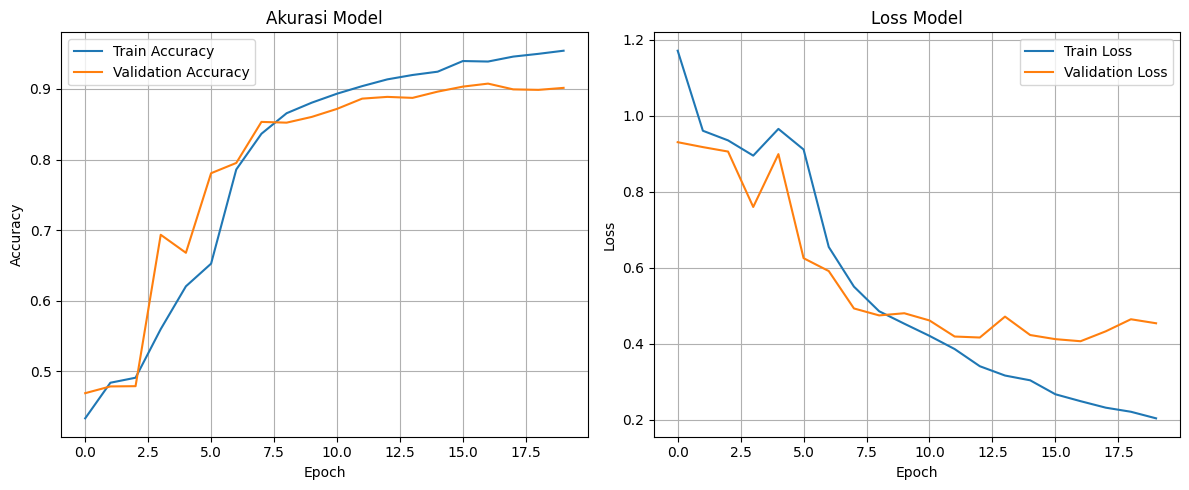

In [22]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


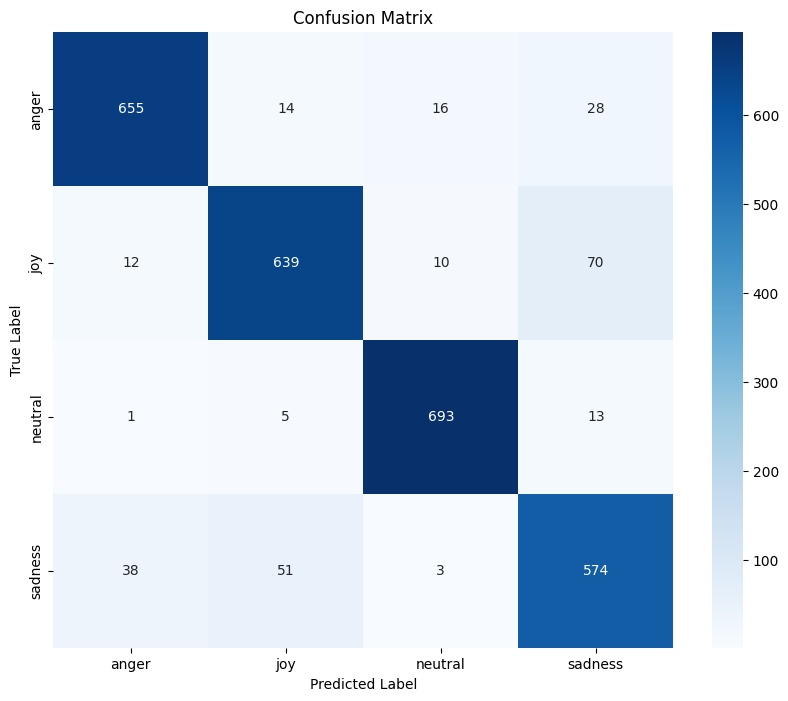

In [23]:

y_pred_prob = model.predict(X_val_pad)   
y_pred = np.argmax(y_pred_prob, axis=1)  

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [24]:
folder_path = "./model"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' telah dibuat.")
else:
    print(f"Folder '{folder_path}' sudah ada.")

Folder './model' sudah ada.


SaveModel

In [25]:
model.save("./model/ED_model.keras") 
print("Model berhasil disimpan.")

Model berhasil disimpan.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Load model
model = tf.keras.models.load_model("./model/ED_model.keras")
print("Model .keras berhasil dimuat.")

# Load tokenizer
with open('tokenizer.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)
print("Tokenizer berhasil dimuat.")

# Konfigurasi
maxlen = 37
label_mapping = {0: 'anger', 1: 'joy', 2: 'neutral', 3: 'sadness'}

# Slang words
slangwords = {
    "@": "di", "abis": "habis", "masi": "masih", "gua": "saya", "gw": "saya", "klo": "kalau", "afk": "tidak aktif",
    "thx": "terima kasih", "ty": "terima kasih", "tq": "terima kasih", "bgt": "banget", "maks": "maksimal",
    "gg": "hebat", "noob": "pemula", "poke": "pemula", "op": "terlalu kuat", "ez": "mudah", "dll": "dan lain lain",
}

# Stopwords
stopword_factory = StopWordRemoverFactory()
list_stopwords = set(stopword_factory.get_stop_words())
list_stopwords.update(stopwords.words('english'))
list_stopwords.update(['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', "di", "ga", "ya", "gaa", "loh", "kah", "woi", "woii", "woy", "nge"])

# Stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# Fungsi preprocessing
def cleaning_text(text):
    emoticon_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoticon_pattern.sub(r'', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = text.replace('\n', ' ').translate(str.maketrans('', '', string.punctuation)).strip()
    return text.lower()

def fix_slangwords(text):
    return ' '.join([slangwords.get(word, word) for word in text.split()])

def tokenizing_text(text):
    return word_tokenize(text)

def filtering_text(tokens):
    return [word for word in tokens if word not in list_stopwords]

def stemming_text(tokens):
    return ' '.join([stemmer.stem(word) for word in tokens])

def preprocess_sentence(sentence):
    cleaned = cleaning_text(sentence)
    fixed = fix_slangwords(cleaned)
    tokens = tokenizing_text(fixed)
    filtered = filtering_text(tokens)
    stemmed = stemming_text(filtered)
    return stemmed

# Fungsi prediksi
def predict_emotion(sentence):
    preprocessed_sentence = preprocess_sentence(sentence)
    sequence = tokenizer.texts_to_sequences([preprocessed_sentence])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen, truncating='post')

    predictions = model.predict(padded_sequence)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_label = label_mapping.get(predicted_class_index, 'Unknown')

    return predicted_label, predictions[0]

if __name__ == "__main__":
    new_sentence = "saya sedih sekali hari ini karena sudah tidak ada lagi teman bermain"
    predicted_label, probabilities = predict_emotion(new_sentence)

    print(f"Sentence: {new_sentence}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Probabilities: {probabilities}")


Model .keras berhasil dimuat.
Tokenizer berhasil dimuat.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Sentence: saya sedih sekali hari ini karena sudah tidak ada lagi teman bermain
Predicted Emotion: neutral
Probabilities: [0.03083706 0.00756259 0.9593469  0.00225344]
